# 03 – Real Data (Two-Regime Buffered AR) with Offline Fallback

[WARN] failed VT: Too Many Requests. Rate limited. Try after a while.
[WARN] failed BND: Too Many Requests. Rate limited. Try after a while.
[WARN] failed GC=F: Too Many Requests. Rate limited. Try after a while.
[WARN] failed DX=F: Too Many Requests. Rate limited. Try after a while.
[WARN] failed BTC-USD: Too Many Requests. Rate limited. Try after a while.
[WARN] failed ETH-USD: Too Many Requests. Rate limited. Try after a while.
[WARN] failed ACWI: Too Many Requests. Rate limited. Try after a while.
[WARN] failed AGG: Too Many Requests. Rate limited. Try after a while.
[WARN] failed GLD: Too Many Requests. Rate limited. Try after a while.
[WARN] failed UUP: Too Many Requests. Rate limited. Try after a while.
[FALLBACK] Using local CSV due to download issue: No data downloaded. Failed: ['VT', 'BND', 'GC=F', 'DX=F', 'BTC-USD', 'ETH-USD', 'ACWI', 'AGG', 'GLD', 'UUP']
[INFO] data_source=local_csv, y=BTC-USD, z=DX=F, n=312
Selected objective: {'objective': 5.2096324731543255}
Params (IN/O

/var/folders/0c/vn7z40yn6qq65v67wpzp2lw00000gn/T/ipykernel_1777/1645426825.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_level = px_w[z_col].reindex(y.index).fillna(method="ffill")


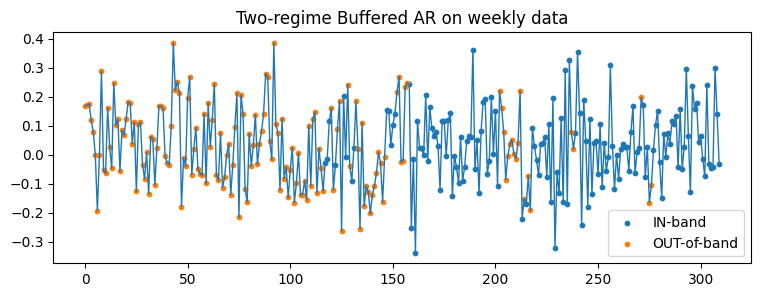

Saved: figs/buffered_two_regime_plot.png, figs/params_buffered_two_regime.csv


In [1]:
import sys, os
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[0]))  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from src.buffered_tar import BufferedTAR

#config
START = "2016-01-01"
END = None
FORCE_TICKERS = False
FORCE_Y = "BTC-USD"       # 作为 y（收益序列）
FORCE_Z = "DX=F"          # 作为 z（水平序列，美元指数期货主连）

#helpers
def fetch_closes(symbols, start=None, end=None, auto_adjust=True, quiet=False):
    """逐支下载；失败不影响其他；返回 Close 列合并后的 DataFrame。"""
    frames, failed = [], []
    for s in symbols:
        try:
            df = yf.Ticker(s).history(start=start, end=end, auto_adjust=auto_adjust, actions=False)
            if df is None or df.empty:
                df = yf.download(s, start=start, end=end, auto_adjust=auto_adjust, progress=False)
            if df is None or df.empty:
                failed.append(s)
                if not quiet: print(f"[WARN] empty data for {s}")
                continue
            # 索引规范化（去时区、排序、去重）
            df.index = pd.to_datetime(df.index, errors="coerce")
            df = df[~df.index.isna()].sort_index()
            try:
                df = df.tz_localize(None)
            except Exception:
                pass
            df = df[~df.index.duplicated(keep="last")]
            col = "Close" if "Close" in df.columns else df.columns[0]
            frames.append(df[[col]].rename(columns={col: s}))
        except Exception as e:
            failed.append(s)
            if not quiet: print(f"[WARN] failed {s}: {e}")
    if not frames:
        raise ValueError(f"No data downloaded. Failed: {failed}")
    out = pd.concat(frames, axis=1).dropna(axis=1, how="all")
    if not quiet and failed:
        print("[INFO] failed tickers:", failed)
    return out

def first_available(cols, priority):
    for c in priority:
        if c in cols:
            return c
    return cols[0]

#try yfinance online first
tickers = ['VT','BND','GC=F','DX=F','BTC-USD','ETH-USD','ACWI','AGG','GLD','UUP']
try:
    px = fetch_closes(tickers, start=START, end=END, auto_adjust=True)
    px.index = pd.to_datetime(px.index, errors="coerce")
    px = px[~px.index.isna()].sort_index()
    try: px = px.tz_localize(None)
    except Exception: pass
    px = px[~px.index.duplicated(keep="last")]
    px_w = px.resample("W-FRI").last()
    source_used = "yfinance"
except Exception as e:
    print("[FALLBACK] Using local CSV due to download issue:", e)

    #离线CSV多路径查找（notebooks下运行时，根目录是上一级）
    ROOT = Path().resolve().parents[0]
    candidates = [
        ROOT / "data" / "example_prices_weekly.csv",
        Path("example_prices_weekly.csv"),
        Path("data") / "example_prices_weekly.csv",
        ROOT / "notebooks" / "data" / "example_prices_weekly.csv",
    ]
    csv_path = None
    for p in candidates:
        if p.exists():
            csv_path = p
            break

    #若仍找不到，现场生成一份极小周频示例并保存到 ROOT/data 下
    if csv_path is None:
        (ROOT / "data").mkdir(exist_ok=True)
        idx = pd.date_range("2019-01-04", "2024-12-27", freq="W-FRI")
        np.random.seed(7)
        def make_price(mu=0.06, vol=0.18, start=100.0):
            r = np.random.normal(mu/52, vol/np.sqrt(52), len(idx))
            return start * np.exp(np.cumsum(r))
        df_gen = pd.DataFrame({
            "VT": make_price(0.06, 0.18, 100),
            "BND": make_price(0.03, 0.06, 100),
            "DX=F": make_price(0.00, 0.05, 100),
            "BTC-USD": make_price(0.80, 0.95, 3000),
        }, index=idx)
        csv_path = ROOT / "data" / "example_prices_weekly.csv"
        df_gen.to_csv(csv_path, index_label="Date")
        print(f"[FALLBACK] generated offline CSV at {csv_path}")

    px_w = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    source_used = "local_csv"
    # 保险起见再规范一次索引
    px_w.index = pd.to_datetime(px_w.index, errors="coerce")
    px_w = px_w[~px_w.index.isna()].sort_index()
    px_w = px_w[~px_w.index.duplicated(keep="last")]

#returns & choose y/z ---
ret_w = px_w.pct_change()

if FORCE_TICKERS:
    # 强制使用指定列；如不存在，会回退到 first_available
    y_col = FORCE_Y if FORCE_Y in ret_w.columns else first_available(ret_w.columns, [FORCE_Y])
    z_col = FORCE_Z if FORCE_Z in px_w.columns else first_available(px_w.columns, [FORCE_Z])
else:
    y_col = first_available(ret_w.columns, ['BTC-USD','ETH-USD','VT','ACWI','GLD','GC=F'])
    z_col = first_available(px_w.columns,  ['UUP','DX=F','^DXY','DX-Y.NYB','VT','ACWI'])

y = ret_w[y_col].dropna()
z_level = px_w[z_col].reindex(y.index).fillna(method="ffill")
y_np, z = y.values, z_level.values

print(f"[INFO] data_source={source_used}, y={y_col}, z={z_col}, n={len(y_np)}")

#fit two-regime buffered AR
model = BufferedTAR.grid_search(y_np, z, mode="two")  # 两系数：IN/OUT
print("Selected objective:", model.selected_)
print("Params (IN/OUT):", {k:(v.round(4).tolist() if v is not None else None) for k,v in model.params_.items()})

#plot & save artifacts
from pathlib import Path
Path("figs").mkdir(exist_ok=True)

Y = y_np[model.p:]
IN = model.masks_["M"]
OUT = ~IN
idx = np.arange(len(Y))

plt.figure(figsize=(9,3))
plt.plot(Y, lw=1)
plt.scatter(idx[IN], Y[IN], s=10, label="IN-band")
plt.scatter(idx[OUT], Y[OUT], s=10, label="OUT-of-band")
plt.title("Two-regime Buffered AR on weekly data")
plt.legend()
plt.savefig("figs/buffered_two_regime_plot.png", dpi=160, bbox_inches="tight")
plt.show()

pd.DataFrame({k:(v if v is None else v.round(6)) for k,v in model.params_.items()}).to_csv(
    "figs/params_buffered_two_regime.csv"
)
print("Saved: figs/buffered_two_regime_plot.png, figs/params_buffered_two_regime.csv")
